In [3]:
import sys
!{sys.executable} -m pip install -r requirements.txt


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\Richard\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import pandas as pd
import zipfile
import os

# Extract the zip file
with zipfile.ZipFile('tanner_dataset.csv.zip', 'r') as zip_ref:
    zip_ref.extractall()

file_path = 'features_tanner_dataset.csv'
df = pd.read_csv(file_path)

df.head()


,path & payload,label,url_len,url_n_dot,url_blacklist,url_entropy,url_suspicious_keyword,url_n_digit,url_n_special,url_n_upper,...,L_IP_Host,L_Hyphen_In_Path,L_ForwardSlash_In_Path,L_Equals_In_Path,L_AtSign_In_URL,L_Username_In_URL,L_NonStdPort,L_URL_BlacklistedWordAppears,L_Host_HasPortNum,L_Host_NumOfTokens
0,/%C0%AE%C0%AE/%C0%AE%C0%AE/%C0%AE%C0%AE/%C0%AE...,Unknown,81,1,0,3.364947,0,10,28,30,...,0,0,7,0,0,0,0,0,0,1
1,/setup.php,Index,11,1,0,3.027169,0,0,2,0,...,0,0,1,0,0,0,0,0,0,1
2,/sitemap.xml,Index,13,1,0,3.546594,0,0,2,0,...,0,0,1,0,0,0,0,0,0,1
3,/OpenVASTest768531477.html,Index,27,1,0,4.430632,0,9,2,5,...,0,0,1,0,0,0,0,0,0,1
4,/wp-admin/,Index,11,0,0,3.277613,0,0,3,0,...,0,1,2,0,0,0,0,0,0,1


In [5]:
# Remove duplicates
df = df.drop_duplicates()

df.duplicated().sum()


np.int64(0)

In [6]:
missing_values = df.isnull().sum()

#Drop rows with missing values
df = df.dropna()

df.isnull().sum()


path & payload                  0
label                           0
url_len                         0
url_n_dot                       0
url_blacklist                   0
                               ..
L_Username_In_URL               0
L_NonStdPort                    0
L_URL_BlacklistedWordAppears    0
L_Host_HasPortNum               0
L_Host_NumOfTokens              0
Length: 67, dtype: int64

In [7]:
import numpy as np

#Remove outliers using IQR on numerical columns
def remove_outliers(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns  # Select only numerical columns
    Q1 = df[numeric_cols].quantile(0.25)
    Q3 = df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    df_out = df[~((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df_out

# Apply the function to the dataframe
df_cleaned = remove_outliers(df)

# Check the shape of dataframe 
df_cleaned.shape


(33663, 67)

In [8]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Label Encoding for the 'label' column
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

# TFIDF for the 'path & payload' column
tfidf_vectorizer = TfidfVectorizer(analyzer='char', max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(df['path & payload'])

# Convert the TFIDF matrix to a DataFrame and join with the original DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
df = df.drop(['path & payload'], axis=1).join(tfidf_df)

df.head()



,label,url_len,url_n_dot,url_blacklist,url_entropy,url_suspicious_keyword,url_n_digit,url_n_special,url_n_upper,url_prop_digit,...,¸,¹,º,»,¼,½,¾,¿,â,ã
0,4,81,1,0,3.364947,0,10,28,30,0.123457,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,11,1,0,3.027169,0,0,2,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,13,1,0,3.546594,0,0,2,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,27,1,0,4.430632,0,9,2,5,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,11,0,0,3.277613,0,0,3,0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Accuracy: 0.9424264722277967
Precision: 0.9440585016729094
Recall: 0.9424264722277967
F1 Score: 0.9422107803269438
Confusion Matrix:
[[13830     3     2   651    22    12]
 [   12  8049     0     1     1     0]
 [    1     0   673     0     0     0]
 [ 1779     1     0 10793     1     0]
 [   38     7     1     0   190     8]
 [   42     0     0     0     0  8730]]


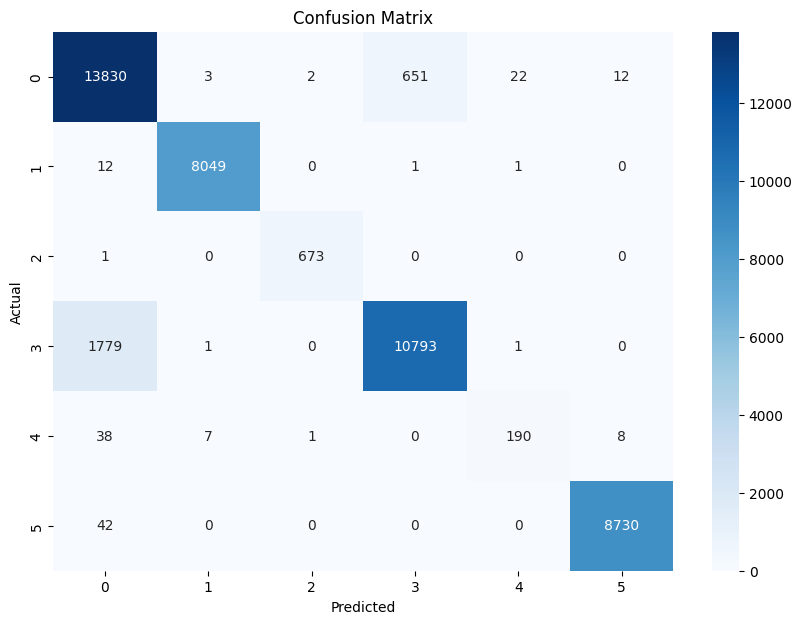

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix, precision_score

# Split the data into features and labels
X = df.drop('label', axis=1)
y = df['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate recall
recall = recall_score(y_test, y_pred, average='weighted')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [10]:
class_distribution = df['label'].value_counts()
print("Class Distribution:")
print(class_distribution)

class_percentage = df['label'].value_counts(normalize=True) * 100
print("\nClass Percentage:")
print(class_percentage)


Class Distribution:
label
0    48193
3    41793
5    29253
1    27171
2     2281
4      797
Name: count, dtype: int64

Class Percentage:
label
0    32.238708
3    27.957428
5    19.568795
1    18.176041
2     1.525875
4     0.533153
Name: proportion, dtype: float64


In [11]:
summary_statistics = df.groupby('label').agg(['mean', 'std', 'min', 'max', 'median'])
print("Summary Statistics by Class:")
print(summary_statistics)


Summary Statistics by Class:
          url_len                                url_n_dot                 \
             mean          std min    max median      mean        std min   
label                                                                       
0      364.787687  1399.339509   1  45578   91.0  5.510116  32.099716   0   
1       83.912149   100.558410   1   1076   64.0  7.329395  39.187473   0   
2       51.976326    19.938686  10    127   48.0  1.293292   0.679521   0   
3       78.096763    82.078042   1   5436   54.0  0.229369   0.754917   0   
4       53.417817   122.561521   5   1896   21.0  1.900878   2.534974   0   
5      115.668068   175.149325   5  11312   95.0  2.016785   4.859438   0   

                    ...         â                                         ã  \
        max median  ...      mean       std  min       max median      mean   
label               ...                                                       
0      1209    1.0  ...  0.005955  0.046

Correlation Matrix:
                  label   url_len  url_n_dot  url_blacklist  url_entropy  \
label          1.000000 -0.111027  -0.080967       0.005741     0.207325   
url_len       -0.111027  1.000000   0.671643      -0.000239     0.123435   
url_n_dot     -0.080967  0.671643   1.000000       0.000059    -0.043172   
url_blacklist  0.005741 -0.000239   0.000059       1.000000     0.003443   
url_entropy    0.207325  0.123435  -0.043172       0.003443     1.000000   
...                 ...       ...        ...            ...          ...   
½             -0.011950  0.057619   0.016285      -0.000048     0.008961   
¾              0.000822  0.058792   0.013943      -0.000038     0.005751   
¿             -0.002823  0.002722   0.002010      -0.000009     0.005890   
â             -0.070882  0.082927   0.023056      -0.000270     0.072042   
ã             -0.066930  0.089939   0.025364      -0.000257     0.063251   

               url_suspicious_keyword  url_n_digit  url_n_special  

C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\utils.py:61: UserWarning: Glyph 129 (\x81) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\utils.py:61: UserWarning: Glyph 134 (\x86) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\utils.py:61: UserWarning: Glyph 139 (\x8b) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\seaborn\utils.py:61: UserWarning: Glyph 144 (\x90) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\Users\Richard

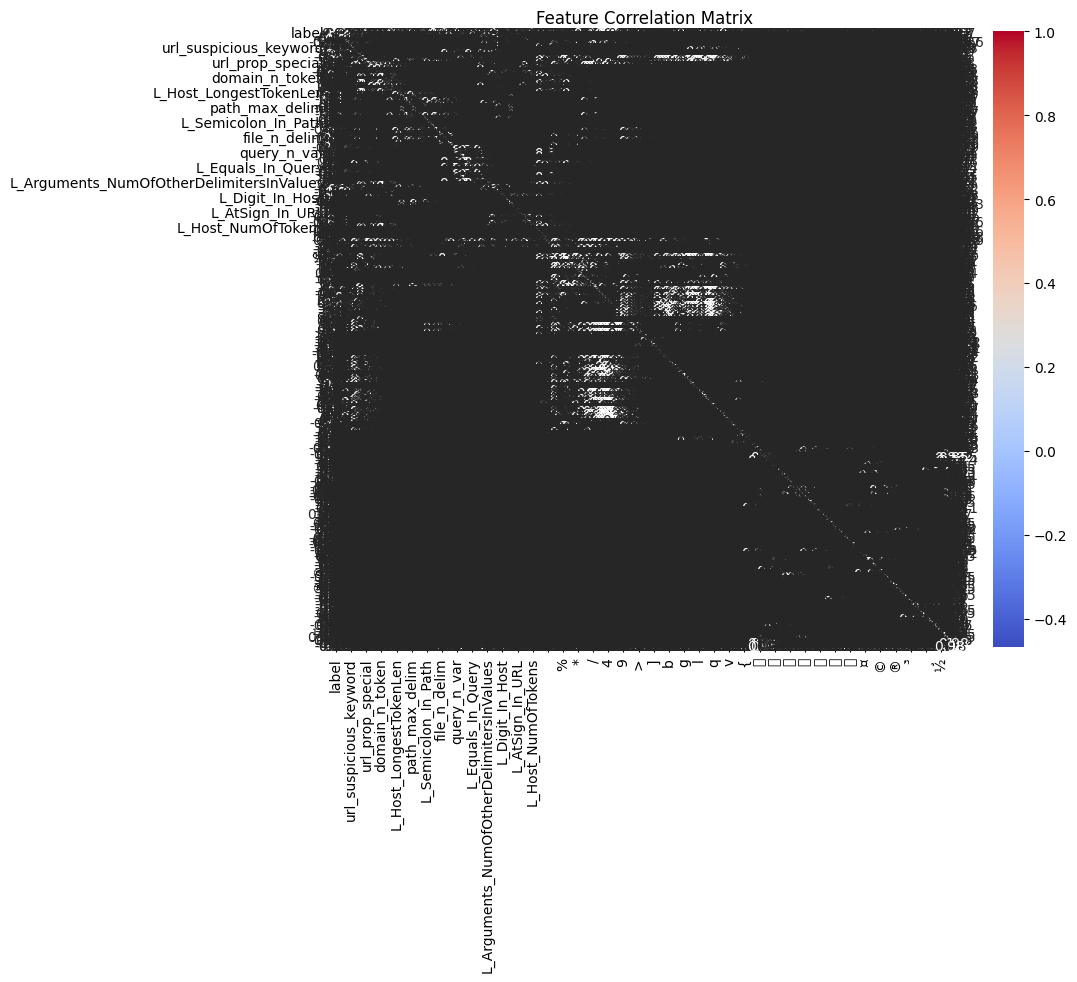

In [12]:
correlation_matrix = df.corr()
print("Correlation Matrix:")
print(correlation_matrix)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()
